In [5]:
import numpy as np
import pandas as pd

import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import add_dummy_feature
from sklearn.preprocessing import label_binarize


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import matthews_corrcoef

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
import mord

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV

from scipy import interp

### Load and Explore Data

In [6]:
df = pd.read_csv('/home/cneiderer/Metis/Neiderer_Metis/Project3/data/winequality-red.csv', delimiter=';')

In [7]:
# Relabel
# df.quality = pd.cut(df.quality, bins=3, labels=[1, 2, 3]).astype('int')
# df.quality = df.quality.map(lambda x: x-3)

In [8]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Subset Data

In [9]:
df_subset = df.copy()
df_subset['quality2'] = pd.cut(df.quality, bins=3, labels=[1, 2, 3])
df_subset['quality2'] = df_subset['quality2'].astype(int)

In [10]:
df_subset['quality2'].value_counts(sort=False)

1      63
2    1319
3     217
Name: quality2, dtype: int64

In [11]:
df_subset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality2
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,2
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,2
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,2
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,2


### Split Data 

In [12]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [13]:
# Split 
# y = resampled_df.quality
# X = resampled_df.drop(columns='quality')

y = df_subset.quality2
X = df_subset.drop(columns=['quality', 'quality2'])

# y = df.quality
# X = df[['fixed acidity', 'volatile acidity', 'free sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']]

# y = df.quality
# X = df.drop(columns='quality')

# X = df[['volatile acidity', 'citric acid', 'total sulfur dioxide', 'density', 'alcohol']]
# X = df[['volatile acidity', 'alcohol']]

# # Make sure intercept exists
# if ~any(X.columns == 'Intercept'):
#     X.insert(0, 'Intercept', 1)
# else: 
#     X.Intercept = 1
    
# Stratified Split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, stratify=y, test_size=.5, random_state=129)

### Bootstrap Resampling

In [14]:
def resample_df(df, target_col, n_samples=None, replace=True):
    
    levels = df[target_col].unique()
    cnts = df[target_col].value_counts()
    
    if n_samples is None:
        n_samples = np.max(cnts)
    elif n_samples == 'max':
        n_samples = np.max(cnts)
    elif n_samples == 'min':
        n_samples = np.min(cnts)    
    elif n_samples == 'med':
        n_samples = np.median(cnts)
        
    df_resampled = pd.DataFrame()    
    for target_class in df[target_col].unique():
        
        df_target_class = df[df[target_col] == target_class]
        df_target_resampled = resample(df_target_class, 
                                       replace=replace,
                                       n_samples=n_samples,
                                       random_state=129)
        df_resampled = pd.concat([df_resampled, df_target_resampled], axis=0)
        
    return df_resampled           

In [15]:
df_train_resampled = resample_df(pd.concat([X_train, y_train], axis=1) , 'quality2', n_samples='max')
X_train = df_train_resampled.drop(columns='quality2')
y_train = df_train_resampled['quality2']

In [16]:
df_test_resampled = resample_df(pd.concat([X_test, y_test], axis=1) , 'quality2', n_samples='max')
X_test = df_test_resampled.drop(columns='quality2')
y_test = df_test_resampled['quality2']

In [17]:
X_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
417,7.0,0.580,0.12,1.9,0.091,34.0,124.0,0.99560,3.44,0.48,10.5
122,7.3,0.695,0.00,2.5,0.075,3.0,13.0,0.99800,3.49,0.52,9.2
386,7.8,0.540,0.26,2.0,0.088,23.0,48.0,0.99810,3.41,0.74,9.2
1568,7.0,0.560,0.13,1.6,0.077,25.0,42.0,0.99629,3.34,0.59,9.2
1539,7.2,0.390,0.32,1.8,0.065,34.0,60.0,0.99714,3.46,0.78,9.9


In [18]:
df_train_resampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1977 entries, 417 to 855
Data columns (total 12 columns):
fixed acidity           1977 non-null float64
volatile acidity        1977 non-null float64
citric acid             1977 non-null float64
residual sugar          1977 non-null float64
chlorides               1977 non-null float64
free sulfur dioxide     1977 non-null float64
total sulfur dioxide    1977 non-null float64
density                 1977 non-null float64
pH                      1977 non-null float64
sulphates               1977 non-null float64
alcohol                 1977 non-null float64
quality2                1977 non-null int64
dtypes: float64(11), int64(1)
memory usage: 200.8 KB


In [19]:
X_test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
25,6.3,0.39,0.16,1.4,0.080,11.0,23.0,0.9955,3.34,0.56,9.3
338,12.4,0.49,0.58,3.0,0.103,28.0,99.0,1.0008,3.16,1.00,11.5
179,8.8,0.61,0.14,2.4,0.067,10.0,42.0,0.9969,3.19,0.59,9.5
1425,8.3,0.26,0.37,1.4,0.076,8.0,23.0,0.9974,3.26,0.70,9.6
93,7.7,0.49,0.26,1.9,0.062,9.0,31.0,0.9966,3.39,0.64,9.6


In [20]:
df_test_resampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1980 entries, 25 to 1299
Data columns (total 12 columns):
fixed acidity           1980 non-null float64
volatile acidity        1980 non-null float64
citric acid             1980 non-null float64
residual sugar          1980 non-null float64
chlorides               1980 non-null float64
free sulfur dioxide     1980 non-null float64
total sulfur dioxide    1980 non-null float64
density                 1980 non-null float64
pH                      1980 non-null float64
sulphates               1980 non-null float64
alcohol                 1980 non-null float64
quality2                1980 non-null int64
dtypes: float64(11), int64(1)
memory usage: 201.1 KB


In [21]:
set(df_train_resampled.index).intersection(set(df_test_resampled.index))

set()

### Helper Functions

In [22]:
def normalize_confusion_matrix(cm):
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    
    #     cm = (cm - np.min(cm)) / (np.max(cm) - np.min(cm))
    
    return cm

In [23]:
def discrete_heatmap(cm):
    
    ### Discrete Confusion Matrix Heatmap
    from sklearn.preprocessing import normalize
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, ax = plt.subplots(figsize=(12, 8))
    
    Z = normalize_confusion_matrix(cm)

    # Generate heatmap
    ax = sns.heatmap(Z, ax=ax, cmap='RdYlGn', annot=True, cbar=True,
                     vmin=0, vmax=1, cbar_kws={'ticks': np.arange(0, 1.2, 0.2)})
    
    ## Format axes object
    #  Format X-axis label and ticks
    ax.set_xlabel('Predicted', fontdict={'size': 12})
    ax.xaxis.set_ticks_position('top') 
    ax.xaxis.set_label_position('top')
    ax.set_xticklabels(['Low', 'Med', 'High'], minor=False)
    
    # Format Y-axis label
    ax.set_ylabel('Truth', fontdict={'size': 12})
    ax.set_yticklabels(['Low', 'Med', 'High'], minor=False)
    
    # Format Title [Note: double newlines are to create space between Title and the X-axis label that was moved to the top]
    ax.set_title('Red Wine Quality\n\n', fontdict={'size': 14, 'weight': 'bold'})
    
    return fig, ax

In [24]:
# def interpolated_heatmap(cm, cb=False):
    
#     ### Interpolated Confusion Matrix Heatmap
#     import numpy as np
#     from sklearn.preprocessing import normalize
#     import matplotlib.pyplot as plt

#     fig, ax = plt.subplots(figsize=(10, 8))
#     ax.patch.set_visible(False)
    
#     Z = normalize_confusion_matrix(cm)

#     # Generate X, Y indices of confusion matrix
#     n_classes = Z.shape[0]
#     X, Y = np.meshgrid(np.arange(0, n_classes, 1), np.arange(n_classes-1, -1, -1))

#     # Plot contours
#     plt.contourf(X, Y, Z, 25, cmap='RdYlGn', vmin=0, vmax=1, )
    
#     if cb:
#         ax2 = plt.colorbar(ticks=np.arange(0, 1.2, 0.2))
    
#     ## Format X-axis label and ticks
#     ax.set_xlabel('Predicted', fontdict={'size': 12})
#     # Move ticks and label to top
#     ax.xaxis.set_ticks_position('top') 
#     ax.xaxis.set_label_position('top')
#     # Hide major tick labels
#     ax.set_xticklabels([], minor=False) 
#     ax.set_xticks([0, 2], minor=False)
#     # Define and label minor ticks
#     ax.set_xticks([0.3, 1, 1.7], minor=True)
#     ax.set_xticklabels(['Low', 'Mid', 'High'], minor=True)

#     ## Format Y-axis label and ticks
#     ax.set_ylabel('Truth', fontdict={'size': 12})
#     # Hide major tick labels
#     ax.set_yticklabels([], minor=False)    
#     # Create and label minor ticks
#     ax.set_yticks([0.3, 1, 1.7], minor=True)
#     ax.set_yticks([0, 2], minor=False)
#     ax.set_yticklabels(['High', 'Mid', 'Low'], minor=True)

#     # Format Title [Note: double newlines are to create space between Title 
#     # and the X-axis label that was moved to the top]
#     ax.set_title('Red Wine Quality\n\n', fontdict={'size': 14, 'weight': 'bold'})
    
#     return fig, axdef plot_roc_curves(y_test, y_pred):

#     fig, ax = plt.subplots(figsize=(10, 8))
#     skplt.metrics.plot_roc_curve(y_test, y_pred, ax=ax)

#     ax.set_xlabel('FPR', fontdict={'size': 12}) #, 'weight': 'bold'})
#     ax.set_ylabel('TPR', fontdict={'size': 12}) #, 'weight': 'bold'})

#     ax.set_title('Red Wine Quality\n', fontdict={'size': 14, 'weight': 'bold'})
    
#     return fig, ax

SyntaxError: invalid syntax (<ipython-input-24-e02a845cfd14>, line 48)

In [25]:
def plot_roc_curves(y_test, y_pred):

    fig, ax = plt.subplots(figsize=(10, 8))
    skplt.metrics.plot_roc_curve(y_test, y_pred, ax=ax)

    ax.set_xlabel('FPR', fontdict={'size': 12}) #, 'weight': 'bold'})
    ax.set_ylabel('TPR', fontdict={'size': 12}) #, 'weight': 'bold'})

    ax.set_title('Red Wine Quality\n', fontdict={'size': 14, 'weight': 'bold'})
    
    return fig, ax

In [26]:
def plot_precision_recall_curves(y_test, y_pred):
    
    fig, ax = plt.subplots(figsize=(10, 8))
    skplt.metrics.plot_precision_recall_curve(y_test, y_pred, ax=ax)
    
    ax.set_xlabel('Recall', fontdict={'size': 12}) #, 'weight': 'bold'})
    ax.set_ylabel('Precision', fontdict={'size': 12}) #, 'weight': 'bold'})

    ax.set_title('Red Wine Quality\n', fontdict={'size': 14, 'weight': 'bold'})
    
    return fig, ax

In [27]:
def error_distance_cost(y_true, y_pred):
    
    cm = confusion_matrix(y_true, y_pred)
    cm = normalize_confusion_matrix(cm)
    
    cost = np.zeros_like(cm)
    rows, cols = cm.shape
    for ridx in range(rows):
        for cidx in range(cols):
            cost[ridx, cidx] = np.abs(ridx-cidx) * cm[ridx, cidx]

    return np.around(1/np.sum(cost), decimals=5)

### Build Models

In [28]:
rf1 = RandomForestClassifier(class_weight='balanced',
                             n_estimators=1000,
                             max_depth=20, 
                             min_samples_leaf=5,
                             random_state=129)
rf1.fit(X_train, y_train)

print(rf1)

rf1_pred = rf1.predict(X_test)

print(classification_report(y_test, rf1_pred))
print(confusion_matrix(y_test, rf1_pred))

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False, random_state=129,
            verbose=0, warm_start=False)
             precision    recall  f1-score   support

          1       0.76      0.18      0.29       660
          2       0.45      0.87      0.59       660
          3       0.87      0.72      0.79       660

avg / total       0.69      0.59      0.55      1980

[[116 544   0]
 [ 14 576  70]
 [ 22 165 473]]


(<matplotlib.figure.Figure at 0x7f045610f438>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f045607c518>)

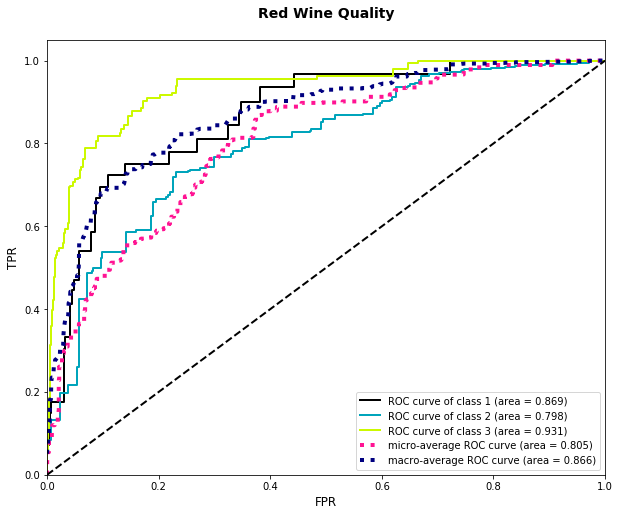

In [31]:
plot_roc_curves(y_test, rf1.predict_proba(X_test))

(<matplotlib.figure.Figure at 0x7f045598f3c8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f045592c358>)

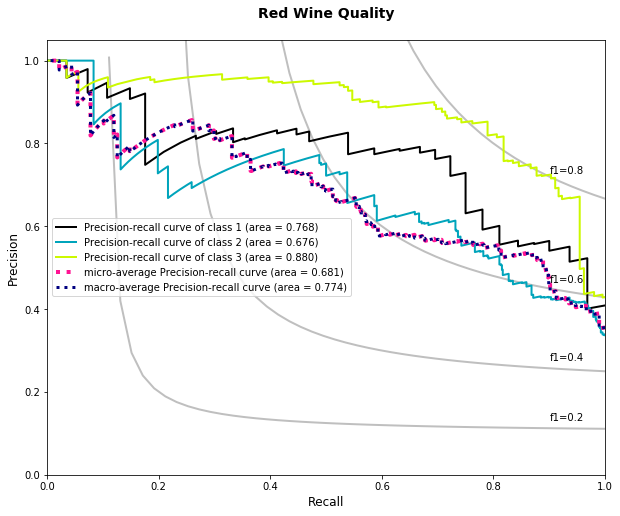

In [32]:
plot_precision_recall_curves(y_test, rf1.predict_proba(X_test))

In [29]:
param_grid = [{'n_estimators': np.logspace(1, 4, 4, dtype=int), 
               'criterion': ['gini', 'entropy'],
              }]

searchcv = GridSearchCV(rf1, param_grid, scoring='accuracy', cv=3, 
                        return_train_score=True, refit=True)

searchcv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False, random_state=129,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': array([   10,   100,  1000, 10000]), 'criterion': ['gini', 'entropy']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [ ]:
print(searchcv.best_estimator_)

rfcv_pred = searchcv.predict(X_test)
rfcv_probas = searchcv.predict_proba(X_test)

print(classification_report(y_test, rfcv_pred))
print(confusion_matrix(y_test, rfcv_pred))

In [ ]:
searchcv.cv_results_['mean_test_score']